# Project 2 TAA

## Expression Recognition with Keras

### Load datasets from file

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#to load matlab mat files
from scipy.io import loadmat
# for neural network
import tensorflow as tf
from tensorflow import keras

import json

# Kfold
from sklearn.model_selection import KFold

# Show images
from PIL import Image
import os

In [2]:
# Intercalar emoções para K-fold validation
def intercalar(x, y, emotionsn=8, samplesPerEmotion=1200):
    print(f"Received x {x.shape} and y {y.shape}")
    newx = np.empty([0,48,48,1])
    newy = np.empty([0,1])
    i=0
    for index in range(samplesPerEmotion):
        for emotion in range(emotionsn):
            # print(index, emotion, y[index+samplesPerEmotion*emotion])
            newx = np.append(newx, x[index+samplesPerEmotion*emotion])
            newy = np.append(newy, y[index+samplesPerEmotion*emotion])
            i+=1
    newx = np.reshape(newx, x.shape)
    newy = np.reshape(newy, y.shape)
    print(f"Returning x {newx.shape} and y {newy.shape}")
    print(newx[0].shape)
    return newx, newy

In [3]:
labelNames = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

# Load Training data cropped
mat=loadmat(f"./datasets/crop/train/{'_'.join(labelNames)}.mat")
# mat is a dict with key "X" for x-values, and key "y" for y values
X_crop, y_crop = np.reshape(mat["X"],(mat["X"].shape[0],mat["X"].shape[1],mat["X"].shape[2],1)), mat["y"]
X_crop, y_crop = intercalar(X_crop, y_crop)

# Load Training data not cropped
mat=loadmat(f"./datasets/no_crop/train/{'_'.join(labelNames)}.mat")
# mat is a dict with key "X" for x-values, and key "y" for y values
X_nocrop, y_nocrop = mat["X"], mat["y"]
#X_nocrop, y_nocrop = intercalar(X_nocrop, y_nocrop)

# Load Test data not cropped
mat=loadmat(f"./datasets/no_crop/test/{'_'.join(labelNames)}.mat")
# mat is a dict with key "X" for x-values, and key "y" for y values
X_nocrop_test, y_nocrop_test = mat["X"], mat["y"]
#X_nocrop_test, y_nocrop_test = intercalar(X_nocrop_test, y_nocrop_test, samplesPerEmotion=200)

# Load Test data cropped
mat=loadmat(f"./datasets/crop/test/{'_'.join(labelNames)}.mat")
# mat is a dict with key "X" for x-values, and key "y" for y values
X_crop_test, y_crop_test = np.reshape(mat["X"], (mat["X"].shape[0],mat["X"].shape[1],mat["X"].shape[2],1)), mat["y"]
X_crop_test, y_crop_test = intercalar(X_crop_test, y_crop_test, samplesPerEmotion=200)

Received x (9600, 48, 48, 1) and y (9600, 1)
Returning x (9600, 48, 48, 1) and y (9600, 1)
(48, 48, 1)
Received x (1600, 48, 48, 1) and y (1600, 1)
Returning x (1600, 48, 48, 1) and y (1600, 1)
(48, 48, 1)


In [4]:
# numbers
m_crop = X_crop.shape[0] # number of training examples
m_nocrop = X_nocrop.shape[0]
labels = int(np.max(y_crop))+1 # number of labels
features = X_crop.shape[1:] # number of features per example

print(f"Loaded {m_crop} traing examples cropped and {m_nocrop} no cropped with {labels} labels ({int(m_crop/labels)} for each), each with {features} features (pixels).")
print("Labels are:", ', '.join(labelNames))

print(f"Loaded {X_crop.shape[0]} dev examples.")

print("X_crop.shape", X_crop.shape)

Loaded 9600 traing examples cropped and 9600 no cropped with 8 labels (1200 for each), each with (48, 48, 1) features (pixels).
Labels are: Neutral, Happy, Sad, Surprise, Fear, Disgust, Anger, Contempt
Loaded 9600 dev examples.
X_crop.shape (9600, 48, 48, 1)


### Some examples

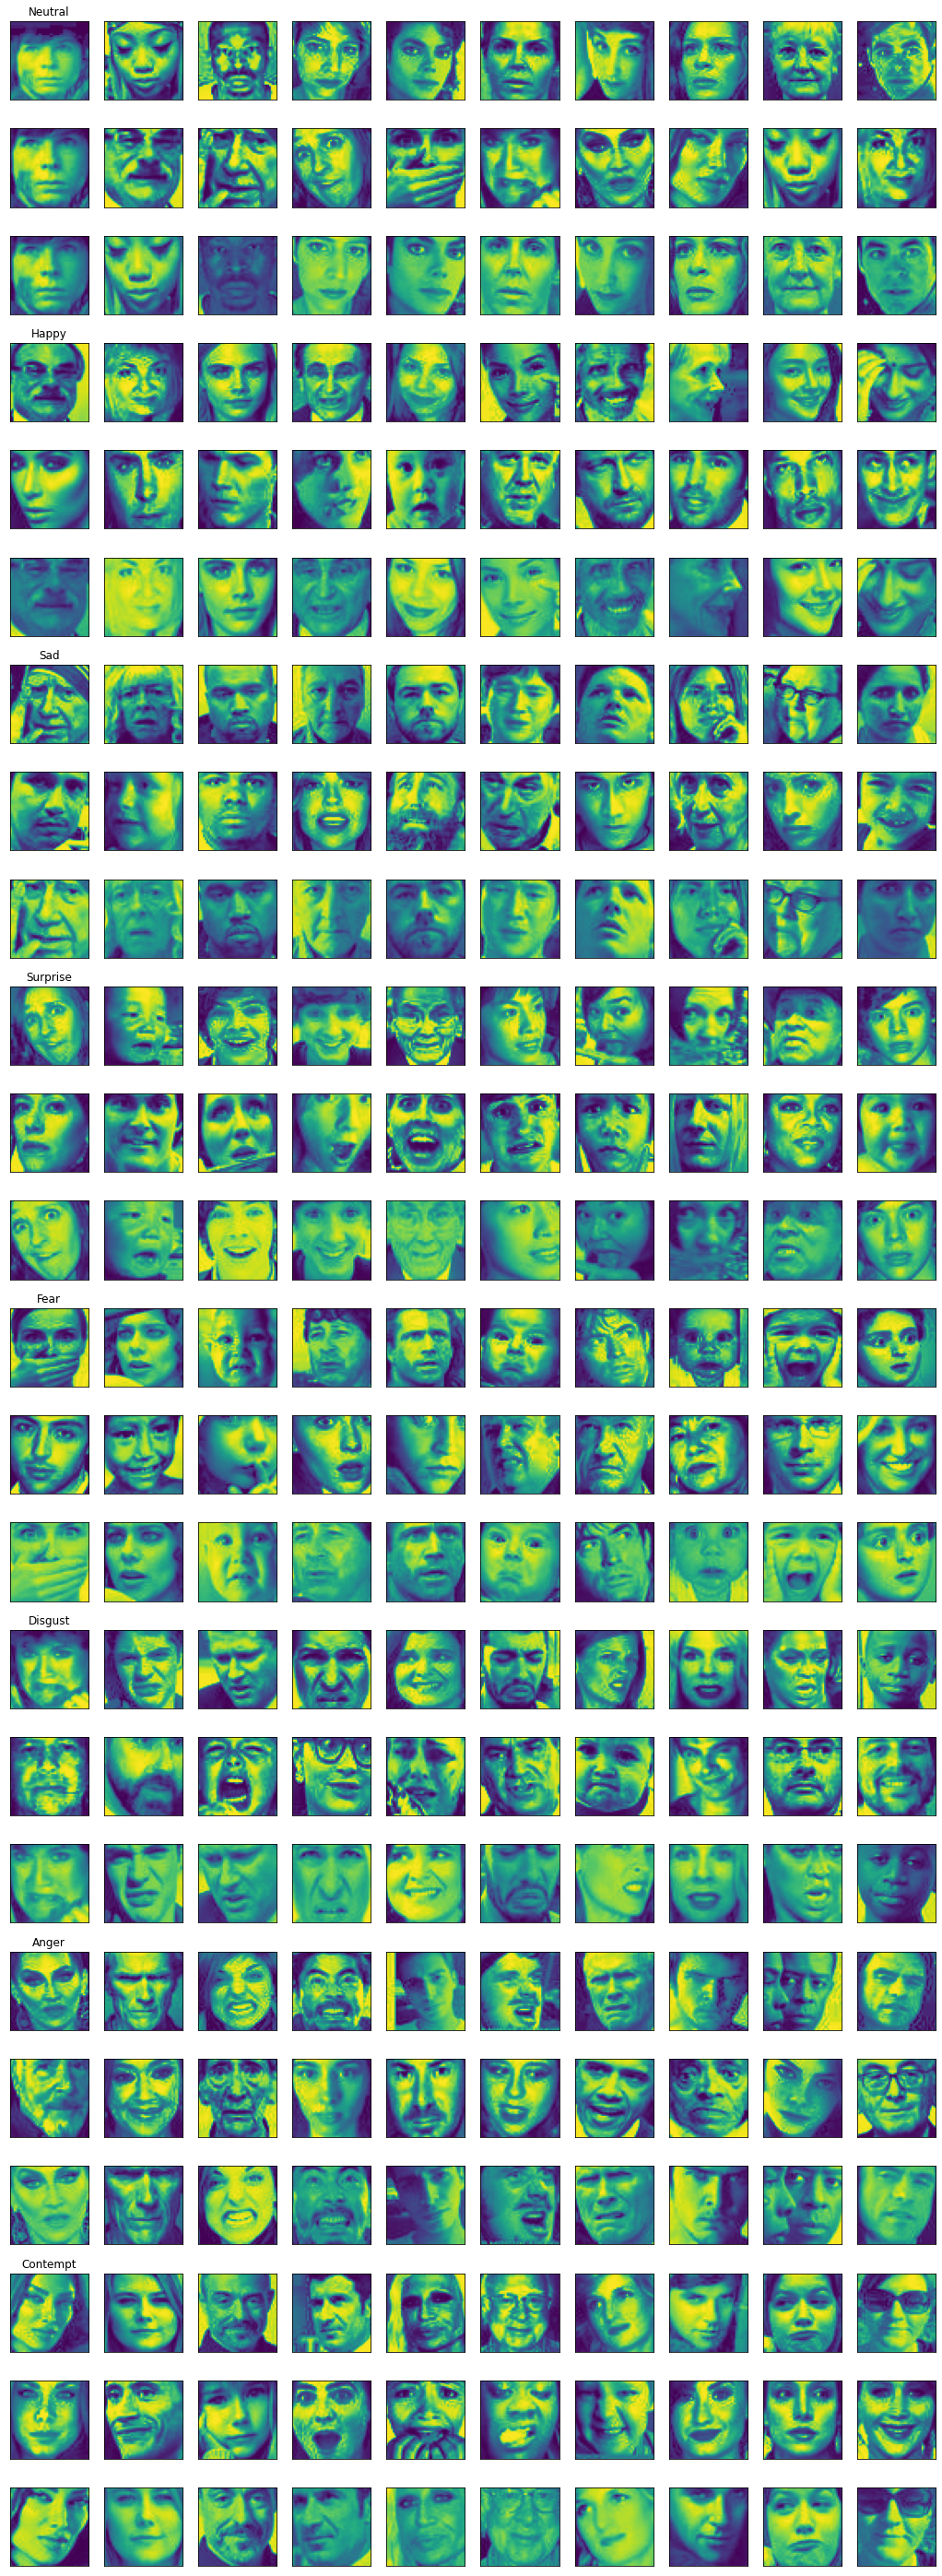

In [5]:
examplesNumber = 10
fig, axis = plt.subplots(int(labels)*3,examplesNumber,figsize=(18,5.5*labels))
fig.subplots_adjust(top=1)

# Foreach label, output 10 random images
for i in range(0, labels*3, 3):
    
    entries_cropped = list(filter(lambda y: '_face' in y, sorted(os.listdir('./data/train_set/processed/' + labelNames[i//3]), key=lambda x:int(x.split('.')[0].split('_')[0]))))
    
    for j in range(0, 10):
        # Show image
        axis[i,j].imshow(X_nocrop[int((m_nocrop/labels)*(i//3)+j),:])
        axis[i+1,j].imshow(X_crop[int((m_crop/labels)*(i//3)+j),:])
        axis[i+2,j].imshow(Image.open('./data/train_set/processed/' + labelNames[i//3] + '/' + entries_cropped[j]).convert('L'))
        # Hide axes
        axis[i,j].set_xticks([])
        axis[i,j].set_yticks([])
        axis[i+1,j].set_xticks([])
        axis[i+1,j].set_yticks([])
        axis[i+2,j].set_xticks([])
        axis[i+2,j].set_yticks([])
        # Display title only on first
        if j==0:
            axis[i,j].set_title(labelNames[i//3])

In [6]:
def create_model(num_features,num_labels, gamma=0):
    model = keras.models.Sequential()
    
    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', input_shape=[48, 48, 1],kernel_regularizer=keras.regularizers.l2(gamma)))
    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.l2(gamma)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(gamma)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.l2(gamma)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.l2(gamma)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.l2(gamma)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.l2(gamma)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(num_features, (3, 3), activation='relu', padding='same',kernel_regularizer=keras.regularizers.l2(gamma)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(num_features, activation='relu',kernel_regularizer=keras.regularizers.l2(gamma)))
    model.add(keras.layers.Dense(num_labels, activation='softmax',kernel_regularizer=keras.regularizers.l2(gamma)))

    return model

In [7]:
def create_model2(num_features,num_labels, gamma=0):
    model = keras.models.Sequential()
    model.add(keras.layers.ZeroPadding2D((3, 3)))
              
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=[48, 48, 1]),kernel_regularizer=keras.regularizers.l2(gamma))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),)

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=[48, 48, 1]),kernel_regularizer=keras.regularizers.l2(gamma))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=[48, 48, 1]),kernel_regularizer=keras.regularizers.l2(gamma))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(num_labels, activation='softmax'),kernel_regularizer=keras.regularizers.l2(gamma))

    return model

In [104]:
#model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd",metrics = ["accuracy"])                 

In [105]:
kFold = KFold()
history=[]
for train, test in kFold.split(X_crop, y_crop):
    print("train", train)
    print("test", test)
   
    print(X_crop.shape)
    model= create_model(64,8)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    history.append(model.fit(X_crop[train], y_crop[train], epochs = 10, validation_data=(X_crop[test], y_crop[test])).history)
    scores = model.evaluate(X_crop[test], y_crop[test])

train [1920 1921 1922 ... 9597 9598 9599]
test [   0    1    2 ... 1917 1918 1919]
(9600, 48, 48, 1)
Epoch 1/10
240/240 [==============================] - 67s 275ms/step - loss: 2.8268 - accuracy: 0.1583 - val_loss: 2.6752 - val_accuracy: 0.1240
Epoch 2/10
240/240 [==============================] - 76s 317ms/step - loss: 2.4357 - accuracy: 0.2693 - val_loss: 2.8012 - val_accuracy: 0.1495
Epoch 3/10
240/240 [==============================] - 78s 327ms/step - loss: 2.2494 - accuracy: 0.3238 - val_loss: 2.5035 - val_accuracy: 0.2469
Epoch 4/10
240/240 [==============================] - 78s 326ms/step - loss: 2.0965 - accuracy: 0.3618 - val_loss: 2.2986 - val_accuracy: 0.3021
Epoch 5/10
240/240 [==============================] - 77s 322ms/step - loss: 1.9918 - accuracy: 0.4063 - val_loss: 2.3324 - val_accuracy: 0.3005
Epoch 6/10
240/240 [==============================] - 76s 317ms/step - loss: 1.8919 - accuracy: 0.4256 - val_loss: 2.0701 - val_accuracy: 0.3661
Epoch 7/10
240/240 [=========

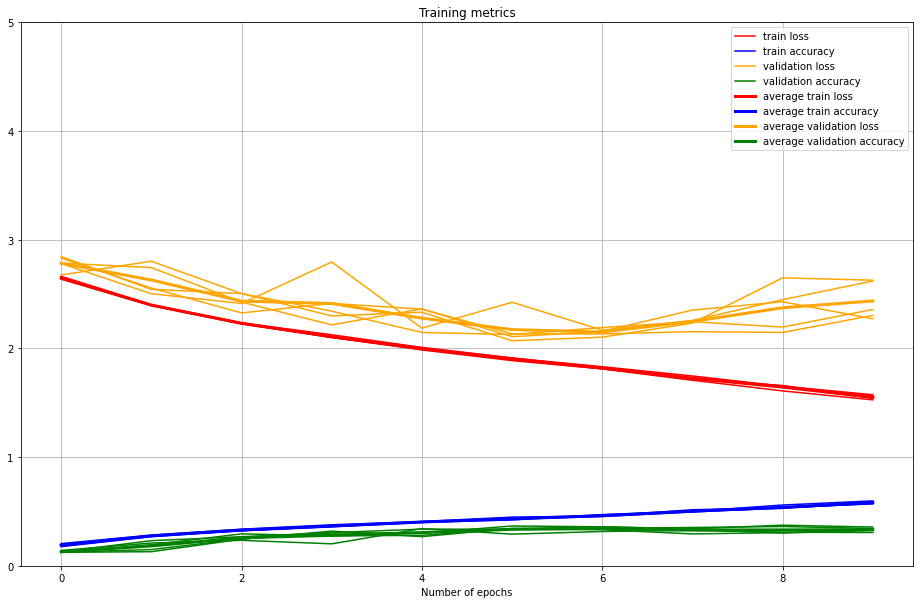

In [136]:
fig= plt.figure()
for i in range(len(history)):
    data= pd.DataFrame(history[i])
    if i==0:
        plt.plot(data["loss"], color="r",label='train loss')
        plt.plot(data["accuracy"], color="b",label='train accuracy')
        plt.plot(data["val_loss"], color="orange", label='validation loss')
        plt.plot(data["val_accuracy"], color="g", label= 'validation accuracy')
    else:
        plt.plot(data["loss"], color="r")
        plt.plot(data["accuracy"], color="b")
        plt.plot(data["val_loss"], color="orange")
        plt.plot(data["val_accuracy"], color="g")
        
    
avg_history={
    
    "train_loss":[sum([h["loss"][i] for h in history])/len(history)for i in range(len(history[0]["loss"]))],
    "train_accuracy":[sum([h["accuracy"][i] for h in history])/len(history)for i in range(len(history[0]["loss"]))],
    "val_loss":[sum([h["val_loss"][i] for h in history])/len(history)for i in range(len(history[0]["loss"]))], 
    "val_accuracy":[sum([h["val_accuracy"][i] for h in history])/len(history)for i in range(len(history[0]["loss"]))]
    
}
plt.plot(avg_history["train_loss"], color="r", lw=3, label='average train loss')
plt.plot(avg_history["train_accuracy"], color="b", lw=3, label='average train accuracy')
plt.plot(avg_history["val_loss"], color="orange", lw=3, label='average validation loss')
plt.plot(avg_history["val_accuracy"], color="g", lw=3, label='average validation accuracy')



plt.grid(True)
fig.set_size_inches(16,10)
plt.gca().set_ylim(0, 5)
plt.title("Training metrics")
plt.xlabel("Number of epochs")
plt.legend()
plt.savefig("./figures/exemple_cross_validation.png")
plt.show()


In [137]:
scores = model.evaluate(X_crop_test, y_crop_test)

50/50 [==============================] - 2s 47ms/step - loss: 2.3356 - accuracy: 0.3444


### Parameter selection

In [17]:
values=[0.001]
val_accuracy={}

for v in values:
    kFold = KFold()
    history=[]
    for train, test in kFold.split(X_crop, y_crop):
        model= create_model(128,8)
        optimizer = keras.optimizers.Adam(lr=v)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=["accuracy"])
        history.append(model.fit(X_crop[train], y_crop[train], epochs = 10, validation_data=(X_crop[test], y_crop[test])).history)
        scores = model.evaluate(X_crop[test], y_crop[test])
        break
    val_accuracy[str(v)]=[sum([h["val_accuracy"][i] for h in history])/len(history)for i in range(len(history[0]["loss"]))]
    
fig= plt.figure()
for l, g in val_accuracy.items():
    plt.plot(g, label=l + " gamma" )

plt.grid(True)
fig.set_size_inches(16,10)
plt.gca().set_ylim(0, 1)
plt.title("Variation of learning rate ")
plt.xlabel("Number of epochs")
plt.legend()
plt.savefig("./figures/learning_validation_test_la_la.png")
plt.show()
with open("./figures/learning_validation_test_lala.json", "w") as f:
    json.dump(val_accuracy, f)

Epoch 1/10
240/240 [==============================] - 212s 872ms/step - loss: 2.2531 - accuracy: 0.1730 - val_loss: 2.1210 - val_accuracy: 0.1505
Epoch 2/10
240/240 [==============================] - 215s 895ms/step - loss: 1.8768 - accuracy: 0.2770 - val_loss: 1.8924 - val_accuracy: 0.2641
Epoch 3/10
240/240 [==============================] - 228s 951ms/step - loss: 1.7474 - accuracy: 0.3305 - val_loss: 1.8073 - val_accuracy: 0.2995
Epoch 4/10
240/240 [==============================] - 225s 938ms/step - loss: 1.6611 - accuracy: 0.3624 - val_loss: 1.7504 - val_accuracy: 0.3229
Epoch 5/10
240/240 [==============================] - 234s 973ms/step - loss: 1.5544 - accuracy: 0.4086 - val_loss: 1.8044 - val_accuracy: 0.3224
Epoch 6/10
240/240 [==============================] - 221s 923ms/step - loss: 1.4451 - accuracy: 0.4570 - val_loss: 1.8220 - val_accuracy: 0.3370
Epoch 7/10
 41/240 [====>.........................] - ETA: 2:53 - loss: 1.3135 - accuracy: 0.5294

KeyboardInterrupt: 

# Final model training

In [28]:
def create_model_final():
    model = keras.models.Sequential()
    
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=[48, 48, 1]))
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))


    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(8, activation='softmax'))

    return model

In [ ]:
model= create_model_final()
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=["accuracy"])
model.fit(X_crop, y_crop, epochs = 7)

Epoch 1/7
300/300 [==============================] - 256s 851ms/step - loss: 2.2096 - accuracy: 0.1728
Epoch 2/7
300/300 [==============================] - 256s 852ms/step - loss: 1.8569 - accuracy: 0.2744
Epoch 3/7
137/300 [============>.................] - ETA: 2:26 - loss: 1.7031 - accuracy: 0.3357

In [108]:
def confusionMatrix(labels, pred, y):
    
    confusionTFPN = {}
    confusionLabels = {}
    
    # Foreach emotion
    for ie in range(len(labels)):
        # TRUE AND FALSE POSITIVES AND NEGATIVES (TFPN)
        
        # Get indexes where emotion was predicted
        ieIndexesPred = [i for i in range(pred.size) if pred[i]==ie]
        ieIndexesNotPred = [i for i in range(pred.size) if pred[i]!=ie]

        # Predicted, and Actual
        TP = sum(pred[:,np.newaxis][ieIndexesPred]==y[ieIndexesPred])
        # Predicted, but not actual
        FP = sum(pred[:,np.newaxis][ieIndexesPred]!=y[ieIndexesPred])
        # Not predicted, but actual
        FN = sum(y[ieIndexesNotPred]==ie)
        # Not predicted and not actual
        TN = sum(y[ieIndexesNotPred]!=ie)

        TP = TP[0] if TP else 0
        FP = FP[0] if FP else 0
        FN = FN[0] if FN else 0
        TN = TN[0] if TN else 0
        
        confusionTFPN[labels[ie]] = {
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN
        }
        
        # CONFUSION WITH OTHER labels (Confusion)
        # For emotion e
        # Count the number of predictions made for all classes
        # Foreach emotion, check how many times it has been predicted 
        
        # Get indexes where emotion is real
        ieIndexesY = [i for i in range(y.size) if y[i]==ie]
        
        # Foreach matching prediction, check what emotion was predicted
        confusionLabels[labels[ie]] = {
            e: sum(pred[:,np.newaxis][ieIndexesY]==labels.index(e))[0] for e in labels
        }
        
    return confusionTFPN, confusionLabels

In [109]:
def outputConfusionTables(labels, testExamplesNumber, confusionTFPN, confusionLabels, axs, axsLine, axsTitle):
     # TABLES
    rows = tuple(labels)
    
    # TABLES / TFPN
    # Output confusion matrix as plot table
    data = [
        [
            f"{vals['TP']} ({vals['TP']/testExamplesNumber*100:.2f}%)",
            f"{vals['TN']} ({vals['TN']/testExamplesNumber*100:.2f}%)",
            f"{vals['TP']+vals['TN']} ({(vals['TP']+vals['TN'])/testExamplesNumber*100:.2f}%)",
            f"{vals['FP']} ({vals['FP']/testExamplesNumber*100:.2f}%)",
            f"{vals['FN']} ({vals['FN']/testExamplesNumber*100:.2f}%)",
            f"{vals['FP']+vals['FN']} ({(vals['FP']+vals['FN'])/testExamplesNumber*100:.2f}%)",
            vals['FP']+vals['FN']+vals['TP']+vals['TN']
        ]
        for _, vals in confusionTFPN.items()
    ]
    columns = ['TP (%)', 'TN (%)', 'T (%)', 'FP (%)', 'FN (%)', 'F (%)', f"Total"]
    
    # Colorize cells depending on value 
    cellColoursTF=plt.cm.Blues([
        [ (vals['TP']+vals['TN'])/testExamplesNumber, (vals['FP']+vals['FN'])/testExamplesNumber ] for _, vals in confusionTFPN.items()
    ])
    cellColourPos=plt.cm.Greens([
        [ vals['TP']/(vals['TP']+vals['FP']), vals['FP']/(vals['TP']+vals['FP']) ] for _, vals in confusionTFPN.items()
    ])
    cellColourNeg=plt.cm.Reds([
        [ vals['TN']/(vals['TN']+vals['FN']), vals['FN']/(vals['TN']+vals['FN']) ] for _, vals in confusionTFPN.items()
    ])
    
    cellColours = [
        [
            cellColourPos[i][0],
            cellColourNeg[i][0],
            cellColoursTF[i][0],
            cellColourPos[i][1],
            cellColourNeg[i][1],
            cellColoursTF[i][1],
            [0, 0, 0, 0]
        ]
        for i in range(len(rows))
    ]
    
    the_table = axs[axsLine].table(
      cellText=data,
      rowLabels=rows,
      colLabels=columns,
      loc='center',
      cellColours=cellColours
    )
    # the_table.scale(1.2, 1)
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(20)
    axs[axsLine].axis('off')
    axs[axsLine].axis('tight')
    axs[axsLine].set_title(f"Confusion matrix {axsTitle}", fontsize=20, y=1.08)    
    
    # TABLES / Confusion    
    # Output confusion matrix as plot table
    data = [[o for _,o in others.items()] for _,others in confusionLabels.items()]
    columns = rows
    
    # Colorize cells depending on value
    vals = [o for _,others in confusionLabels.items() for _,o in others.items()]
    normal = plt.Normalize(min(vals)-1, max(vals)+1)
    cellColours=plt.cm.Blues(normal(data))
        
    the_table = axs[axsLine+1].table(
      cellText=data,
      rowLabels=rows,
      colLabels=columns,
      loc='center',
      cellColours=cellColours
    )
    
    the_table.set_fontsize(20)
    # the_table.scale(1, 4)
    axs[axsLine+1].axis('off')
    axs[axsLine+1].axis('tight')
    axs[axsLine+1].set_title(f"True/Predicted {axsTitle}", fontsize=20, y=1.08)
    

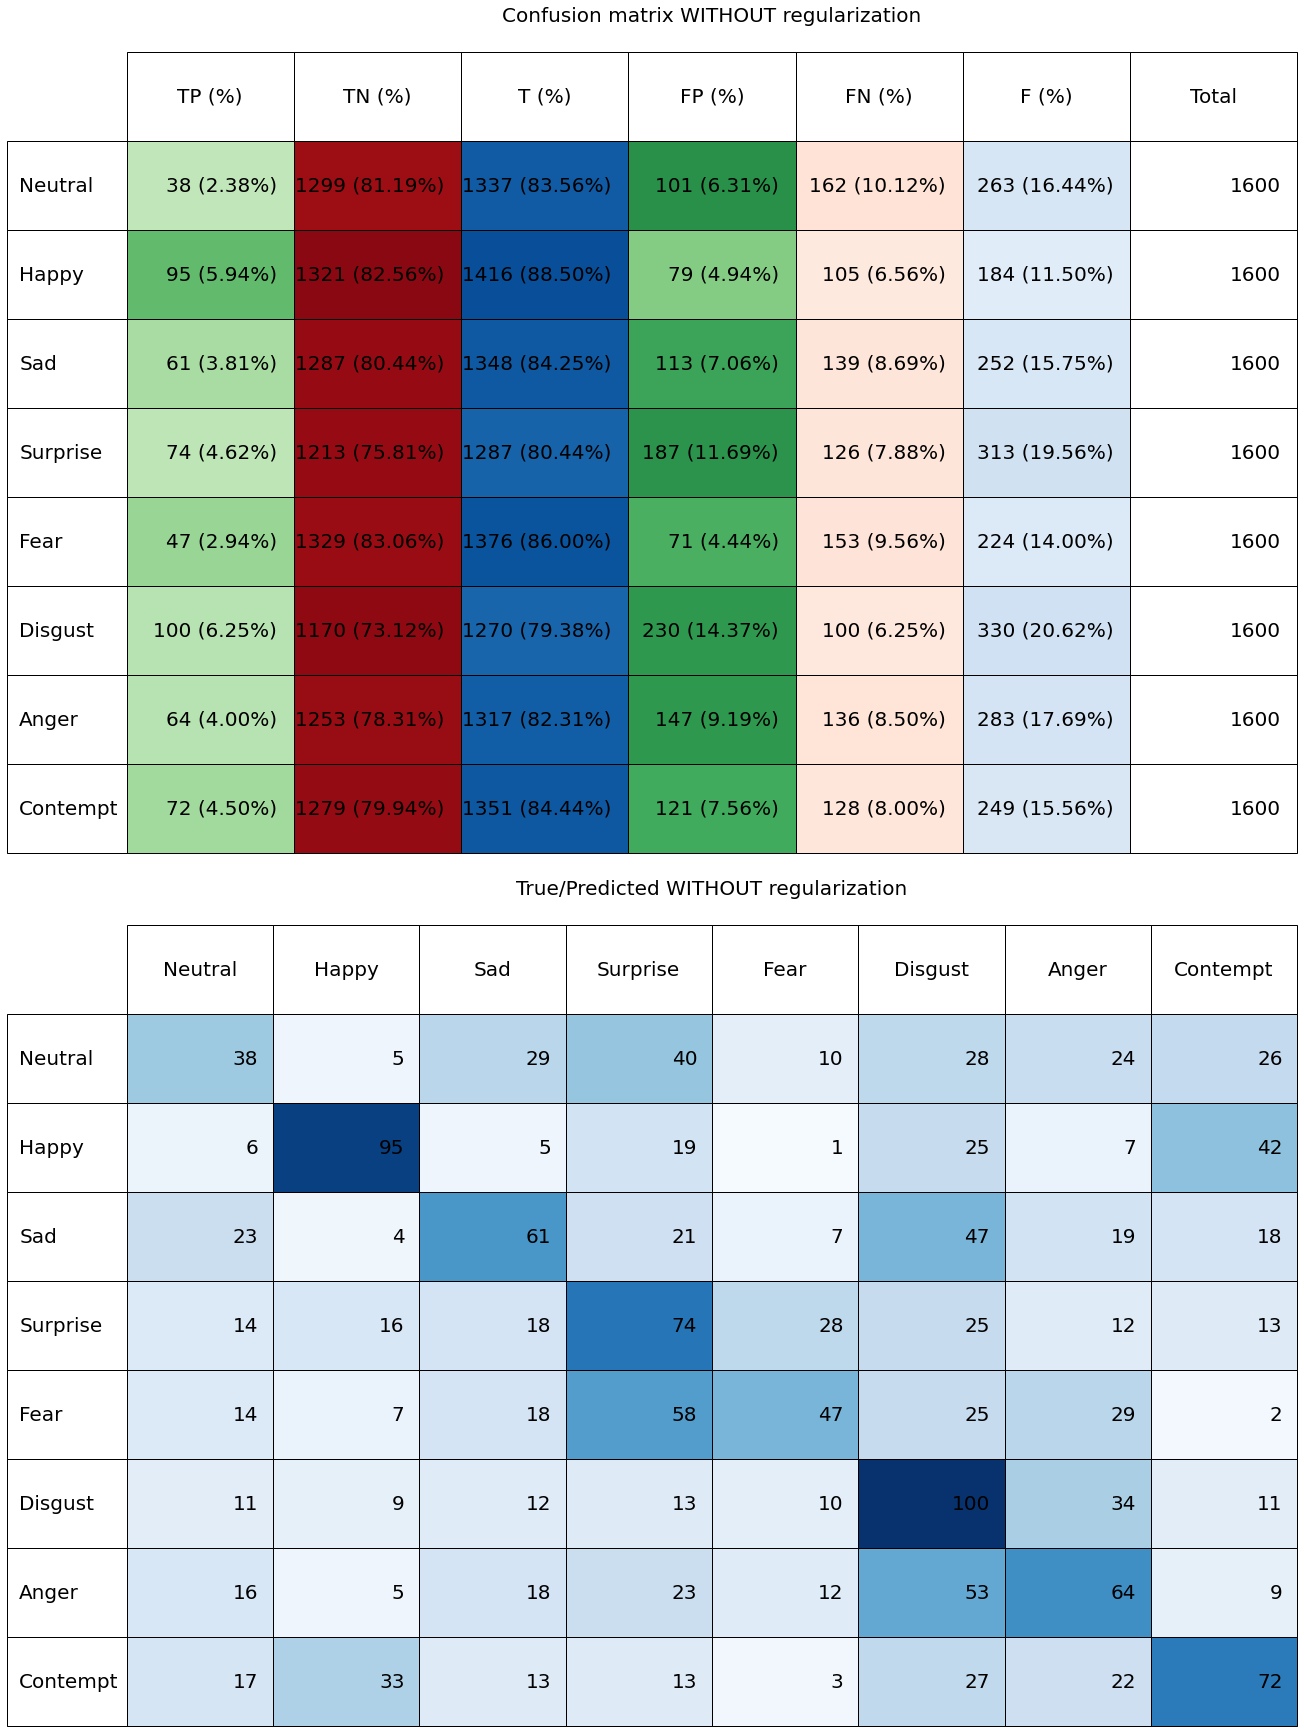

In [110]:
# Get y predicted for test data set
predict = model.predict(X_crop_test)
y_pred = np.array([np.argmax(p) for p in predict])

# Compute confusions
confusionTFPN, confusionLabels = confusionMatrix(labelNames, y_pred, y_crop_test)

# Display as table
fig, axs = plt.subplots(2,1,constrained_layout=True)

outputConfusionTables(labelNames, y_crop_test.size, confusionTFPN, confusionLabels, axs, 0, "WITHOUT regularization")


fig.set_size_inches(18,3*len(labelNames))
#fig.subplots_adjust(left=0.2, top=2)
#fig.tight_layout()

In [12]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 46, 46, 128)       1280      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 46, 46, 128)       147584    
_________________________________________________________________
batch_normalization_21 (Batc (None, 46, 46, 128)       512       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 23, 23, 128)       147584    
_________________________________________________________________
batch_normalization_22 (Batc (None, 23, 23, 128)       512       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 23, 23, 128)      

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 46, 46, 48)        480       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 46, 46, 48)        20784     
_________________________________________________________________
batch_normalization_77 (Batc (None, 46, 46, 48)        192       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 23, 23, 48)        0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 23, 23, 48)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 23, 23, 96)        41568     
_________________________________________________________________
batch_normalization_78 (Batc (None, 23, 23, 96)      

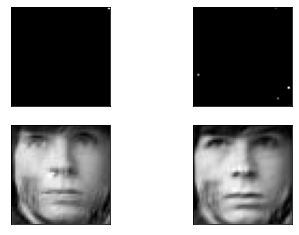

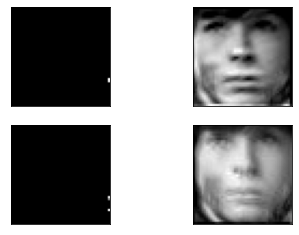

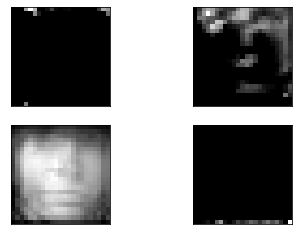

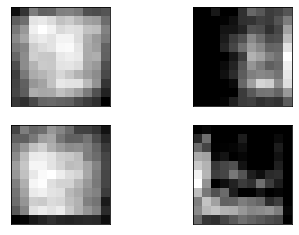

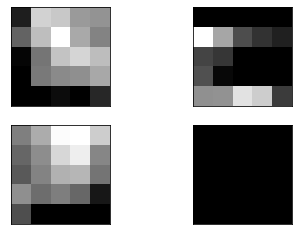

In [40]:
model = create_model(48,8)
model.summary()
# redefine model to output right after the first hidden layer
ixs = [0,1,7,13,19]
outputs = [model.layers[i].output for i in ixs]
model = keras.models.Model(inputs=model.inputs, outputs=outputs)

# get feature map for first hidden layer
feature_maps = model.predict(np.expand_dims(X_crop[0,:],axis=0))
# plot the output from each block
square = 2
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()